In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier

from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#caricamento del dataset
df = pd.read_csv('datasets/penguins.csv')
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


# Esplorazione dei dati

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


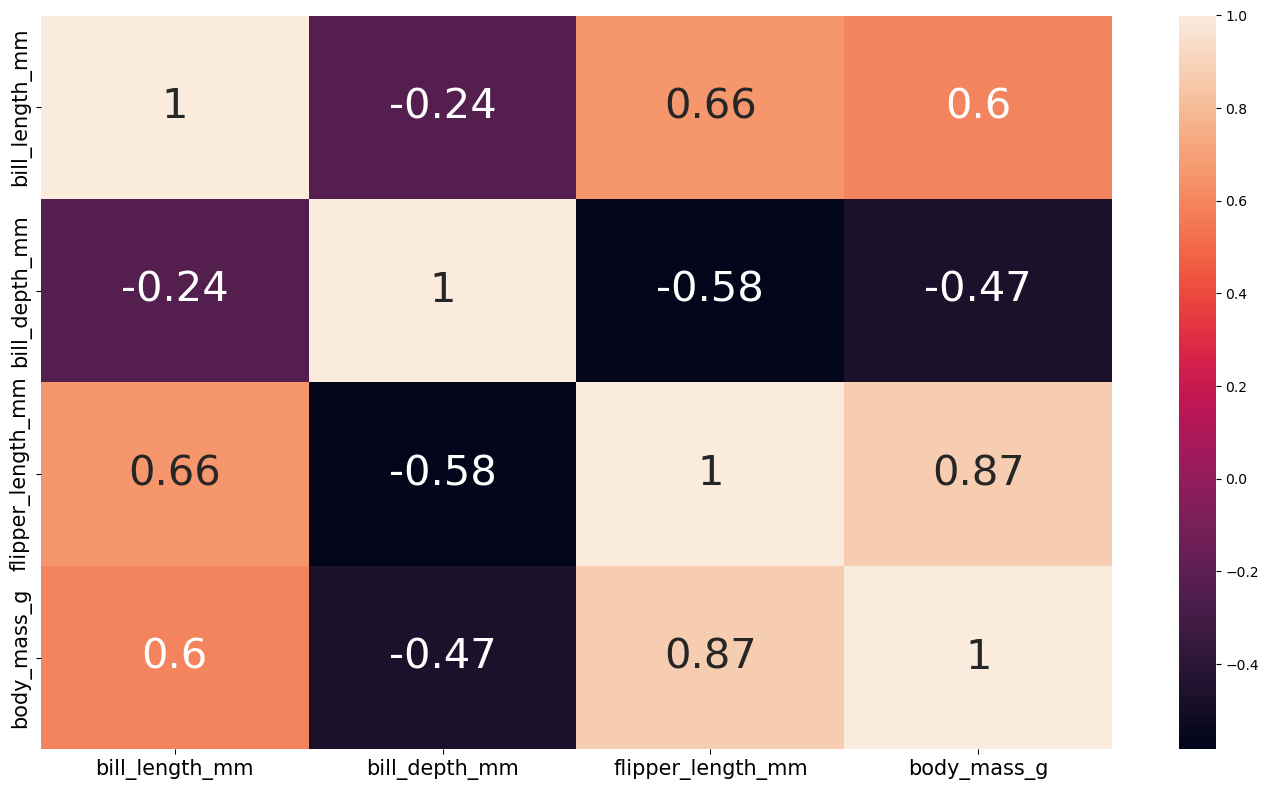

In [4]:
plt.figure(figsize=(14,8))
ax = sns.heatmap(df.corr(),annot=True,annot_kws={'size':30})
ax.tick_params(labelsize=15)
plt.tight_layout()

In [5]:
df.describe(include='all')

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
count,344,344,342.000000,342.000000,342.000000,342.000000,333
unique,3,3,NaN,NaN,NaN,NaN,2
top,Adelie,Biscoe,NaN,NaN,NaN,NaN,MALE
freq,152,168,NaN,NaN,NaN,NaN,168
mean,NaN,NaN,43.921930,17.151170,200.915205,4201.754386,NaN
std,NaN,NaN,5.459584,1.974793,14.061714,801.954536,NaN
min,NaN,NaN,32.100000,13.100000,172.000000,2700.000000,NaN
25%,NaN,NaN,39.225000,15.600000,190.000000,3550.000000,NaN
50%,NaN,NaN,44.450000,17.300000,197.000000,4050.000000,NaN
75%,NaN,NaN,48.500000,18.700000,213.000000,4750.000000,NaN


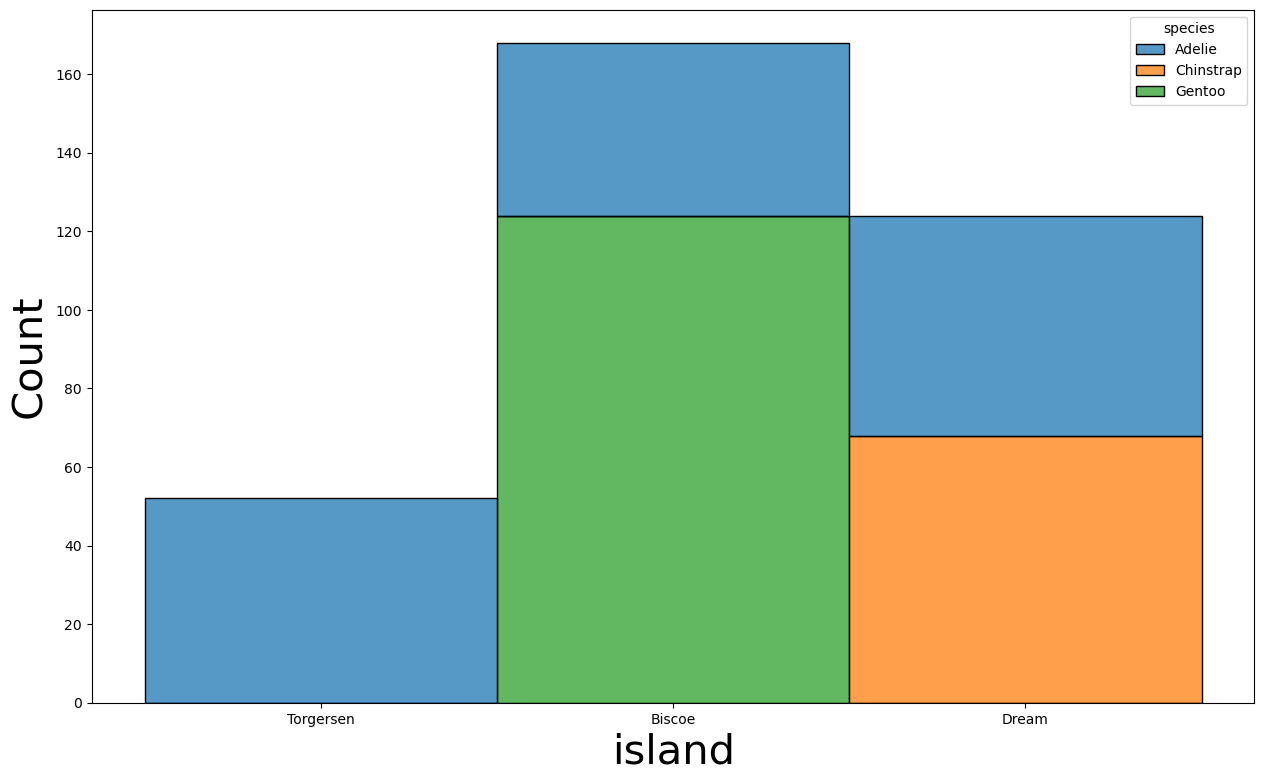

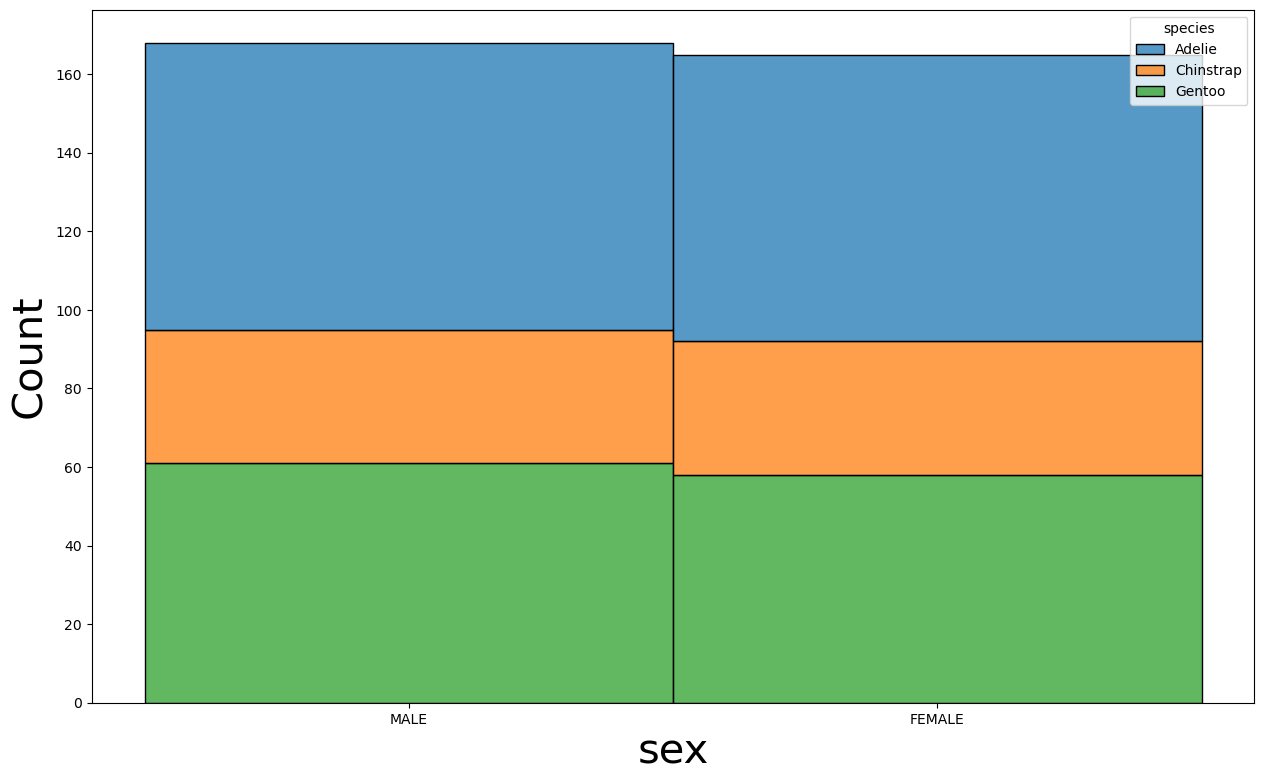

In [6]:
for col in df.select_dtypes(include=['object','bool']).columns[1:]:
    plt.figure(figsize=(15,9))
    ax = sns.histplot(data=df, x=col, binwidth=0.5, hue='species',stat='count',multiple="stack")
    ax.yaxis.label.set_size(30)
    ax.xaxis.label.set_size(30)
    plt.show()

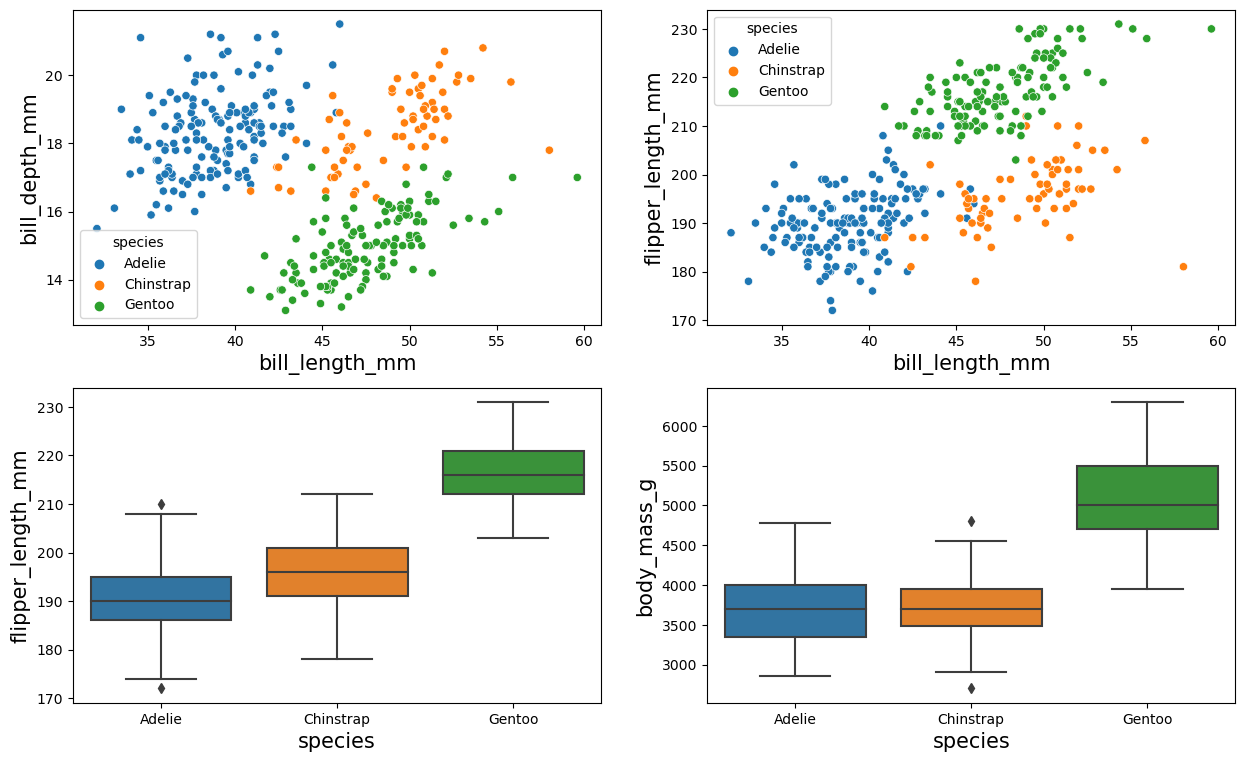

In [7]:
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(15,9))
sns.scatterplot(data=df,x='bill_length_mm',y='bill_depth_mm',hue='species',ax=ax[0,0])
ax[0,0].yaxis.label.set_size(15)
ax[0,0].xaxis.label.set_size(15)

sns.scatterplot(data=df,x='bill_length_mm',y='flipper_length_mm',hue='species',ax=ax[0,1])
ax[0,1].yaxis.label.set_size(15)
ax[0,1].xaxis.label.set_size(15)

sns.boxplot(data=df,x='species',y='flipper_length_mm',ax=ax[1,0])
ax[1,0].yaxis.label.set_size(15)
ax[1,0].xaxis.label.set_size(15)

sns.boxplot(data=df,x='species',y='body_mass_g',ax=ax[1,1])
ax[1,1].yaxis.label.set_size(15)
ax[1,1].xaxis.label.set_size(15)

plt.show()

In [8]:
null_var_num = df.isnull().sum().sort_values(ascending=False)[df.isnull().sum()!=0]
null_var_perc = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)[df.isnull().sum()!=0]
col_nulls = pd.concat([null_var_num,null_var_perc],axis=1,keys=['count','percentual'])
col_nulls

,count,percentual
sex,11,0.031977
bill_length_mm,2,0.005814
bill_depth_mm,2,0.005814
flipper_length_mm,2,0.005814
body_mass_g,2,0.005814


In [9]:
null_var_num = df.isnull().sum(axis=1).sort_values(ascending=False)[df.isnull().sum(axis=1)!=0]
null_var_perc = (df.isnull().sum(axis=1)/df.isnull().count(axis=1)).sort_values(ascending=False)[df.isnull().sum(axis=1)!=0]
row_nulls = pd.concat([null_var_num,null_var_perc],axis=1,keys=['count','percentual'])
row_nulls

,count,percentual
3,5,0.714286
339,5,0.714286
324,1,0.142857
8,1,0.142857
286,1,0.142857
336,1,0.142857
11,1,0.142857
10,1,0.142857
9,1,0.142857
47,1,0.142857


In [10]:
row_nulls[row_nulls['percentual'] > 0.5].index

Int64Index([3, 339], dtype='int64')

# Data Preparation

In [11]:
#pulizia dei dati
df=df.drop(index=row_nulls[row_nulls['percentual'] > 0.5].index,columns=['island'])
df

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,39.1,18.7,181.0,3750.0,MALE
1,Adelie,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,39.3,20.6,190.0,3650.0,MALE
...,...,...,...,...,...,...
338,Gentoo,47.2,13.7,214.0,4925.0,FEMALE
340,Gentoo,46.8,14.3,215.0,4850.0,FEMALE
341,Gentoo,50.4,15.7,222.0,5750.0,MALE
342,Gentoo,45.2,14.8,212.0,5200.0,FEMALE


In [14]:
# codifica one-hot
X = pd.get_dummies(data=df.iloc[:,1:])
y = df.iloc[:,0]

In [15]:
X

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_FEMALE,sex_MALE
0,39.1,18.7,181.0,3750.0,0,1
1,39.5,17.4,186.0,3800.0,1,0
2,40.3,18.0,195.0,3250.0,1,0
4,36.7,19.3,193.0,3450.0,1,0
5,39.3,20.6,190.0,3650.0,0,1
...,...,...,...,...,...,...
338,47.2,13.7,214.0,4925.0,1,0
340,46.8,14.3,215.0,4850.0,1,0
341,50.4,15.7,222.0,5750.0,0,1
342,45.2,14.8,212.0,5200.0,1,0


In [16]:
y

0      Adelie
1      Adelie
2      Adelie
4      Adelie
5      Adelie
        ...  
338    Gentoo
340    Gentoo
341    Gentoo
342    Gentoo
343    Gentoo
Name: species, Length: 342, dtype: object

# Costruzione del modello

In [17]:
#impostazione dei modelli da usare

models = {'Albero Decisionale':DecisionTreeClassifier(max_depth=200,random_state=0,ccp_alpha=0.25),
          'Discriminante logistico':GridSearchCV(LogisticRegression(penalty='l2',random_state=0,max_iter=200),
                                                 {'C':[0.001,0.01,0.1,1.0,10.0,20.0]}),
          'AdaBoost':AdaBoostClassifier(base_estimator=GaussianNB(),n_estimators=100,random_state=0),
          'Random Forest':RandomForestClassifier(max_depth=200,random_state=0,ccp_alpha=0.25)}
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,stratify=y)

In [18]:
#applicazione dei modelli sui dati da usare

sc = StandardScaler()

print(f'{"modello":35} accuracy')
for k in models.keys():
    X_train_sc = sc.fit_transform(X_train)
    X_test_sc = sc.transform(X_test)

    if k in ['Albero Decisionale','Random Forest']:
        models[k].fit(X_train,y_train)
        y_pred = models[k].predict(X_test)
    else:
        models[k].fit(X_train_sc,y_train)
        y_pred = models[k].predict(X_test_sc)
    print(f'{k:35} {accuracy_score(y_test,y_pred):.3f}')

modello                             accuracy
Albero Decisionale                  0.767
Discriminante logistico             1.000
AdaBoost                            1.000
Random Forest                       0.791
